# 実習2-3
### MNISTとMLPでcross-validation(交差検証)

In [1]:
import os  #OSの機能を使用するため
import pandas as pd  #pandasを用いたデータ処理をするため
import keras #Kerasを使用するため
from keras.datasets import mnist #MNISTデータを使用するため
from keras.models import Sequential #Neural Networkを作製するため。
from keras.layers import Dense, Dropout #フルコネクト(fc)層の作製と、ドロップアウトを使用するため
from keras.optimizers import SGD #確率的勾配降下法を使用するため
import matplotlib.pyplot as plt #画像描画のため
import time #計算にかかった時間を表示するため

Using TensorFlow backend.


In [0]:
#バッチサイズ、分類クラス数、epoch数を設定
batch_size = 100
num_classes = 10
epochs = 10

In [3]:
# Mnistデータをダウンロード。既に訓練データとテストデータに分割されている。
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape
#X_train: 学習データ
#y_train: 学習ラベル
#X_test: テストデータ
#y_test: テストラベル

11493376/11490434 [==============================] - 2s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

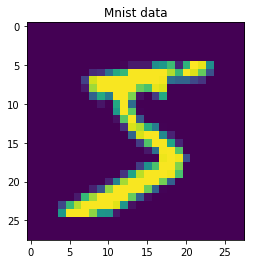

In [4]:
plt.imshow(X_train[0,:28,:28])#画像データのスライス
plt.title('Mnist data')
plt.show()
#Matplotlibについては以下のHPが役に立つかも
#https://matplotlib.org/gallery/index.html

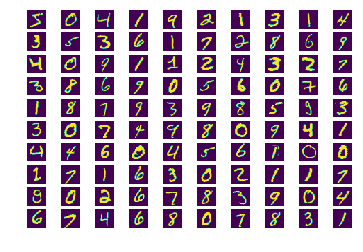

In [5]:
#10x10でデータを表示
import numpy as np
for i in range(100):
    plt.subplot(10,10,i + 1)
    plt.axis("off")
    plt.imshow(X_train[i,:28,:28])
    
plt.show()

In [6]:
#x_trainのデータとy_trainのデータの対応を見る
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [0]:
#データの値を正規化
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

(48000, 28, 28) (12000, 28, 28) (48000,) (12000,)


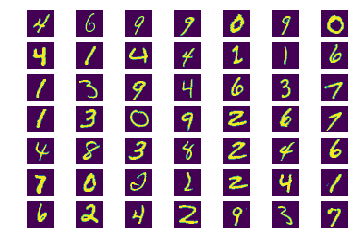

(48000, 28, 28) (12000, 28, 28) (48000,) (12000,)


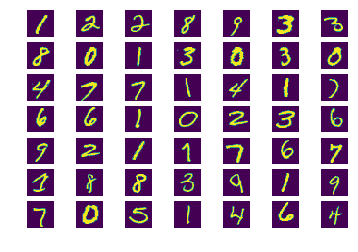

(48000, 28, 28) (12000, 28, 28) (48000,) (12000,)


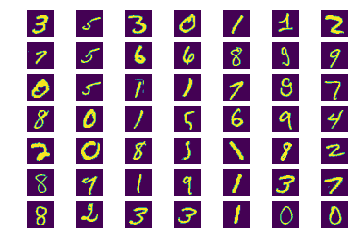

(48000, 28, 28) (12000, 28, 28) (48000,) (12000,)


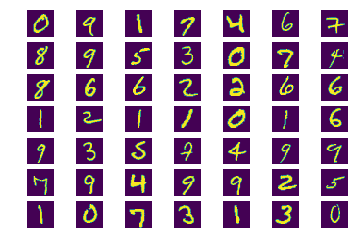

(48000, 28, 28) (12000, 28, 28) (48000,) (12000,)


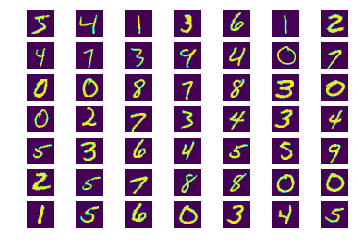

In [8]:
# 5 foldのクロスバリデーションデータの作製を見てみる
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

#shuffle=Trueにすることで、連続する数字の単純なグループ分けではなく、データセットの中からランダムに値を持ってきてグループを作ることができる。
kf = KFold(n_splits=5, shuffle=True)

for train_index, eval_index in kf.split(X_train):
    X_tra, X_eval = X_train[train_index], X_train[eval_index]
    y_tra, y_eval = y_train[train_index], y_train[eval_index]
    print(X_tra.shape, X_eval.shape, y_tra.shape, y_eval.shape)
    for i in range(49):
        plt.subplot(7,7,i + 1)
        plt.axis("off")
        plt.imshow(X_eval[i,:28,:28])
        if i == 48: i = 0
    plt.show()

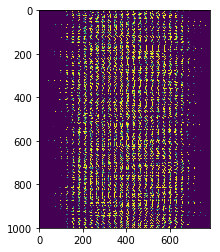

In [9]:
#一次元配列のデータに変換します。
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
plt.imshow(X_train[0:1000, 0:784])
plt.show()

In [0]:
# 教師データ(y_train, y_test)をOne hotベクトルへ変換する
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
#One hotなベクトルになっていることを確認
Y_train[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
from keras.callbacks import ModelCheckpoint #重み保存の際、epochを通して最良の重みを保存するため
from keras.callbacks import CSVLogger #学習結果をcsvに保存するのに使う
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
# Caalbacksについての詳細は以下(https://keras.io/ja/callbacks/)

start = time.time()
kf = KFold(n_splits=5, shuffle=True)
index = 0

# 重みと学習結果の保存先を作成
mnist_MLP_results_dir = 'mnist_MLP_results'
if not os.path.exists(mnist_MLP_results_dir):os.mkdir(mnist_MLP_results_dir)

# クロスバリデーションを実行
for train_index, eval_index in kf.split(X_train):
    X_tra, X_eval = X_train[train_index], X_train[eval_index]
    y_tra, y_eval = Y_train[train_index], Y_train[eval_index]
    
    # 重みの保存先と重みのindexを指定
    model_weights = "mnist_MLP_results/MLP_CV[%d].h5" % index
    
    # 学習結果の保存先とindexの指定
    results = 'mnist_MLP_results/traininglog[%d].csv' % index 
    keras.callbacks.CSVLogger(results, separator=',', append=False)
    csv_logger = CSVLogger(results)
    index += 1  
    
    #MLPのモデル/構造
    model = Sequential()
    model.add(Dense(300, activation='relu', input_shape=(784,)))#入力層のノード数784(=28*28), 第1層のノード数512、活性化関数はrelu
    model.add(Dropout(0.5)) #ドロップアウト率
    model.add(Dense(300, activation='relu'))#第2層のノード数512
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))#最終層のノード数はクラス数と同じ10、活性化関数はsoftmax
    
    # モデルのコンパイル
    model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),#lrはlearning rate
              metrics=['accuracy']) 
    
    # モデル重みデータの保存 (monitor: 監視する値, save_best_only=Trueの場合，監視しているデータの最良モデルが上書きされない)
    # 各epochで最良の重みが保存される
    checkpointer = ModelCheckpoint(model_weights, monitor='val_loss', verbose=1, save_best_only=True)
    
    # 学習
    hist = model.fit(X_tra, y_tra,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_eval, y_eval),
                    callbacks=[checkpointer, csv_logger]) # checkpointとcsv保存機能を使用する際に必要
    
    # lossとAccuracyを出す
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

elapsed_time = time.time() - start #(処理時間)＝(処理が終わった時間)ー(処理を始めた時間)
print("計算時間:",elapsed_time,"秒") 

#モデルをjsonファイルに保存
model_json_str = model.to_json()
open("mnist_MLP_results/mnist_MLP_model.json", "w").write(model_json_str)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 48000 samples, validate on 12000 samples
Epoch 1/10





48000/48000 [==============================] - 7s 145us/step - loss: 1.6099 - acc: 0.4735 - val_loss: 0.7564 - val_acc: 0.8283

Epoch 00001: val_loss improved from inf to 0.75638, saving model to mnist_MLP_results/MLP_CV[0].h5
Epoch 2/10
48000/48000 [==============================] - 2s 50us/step - loss: 0.8459 - acc: 0.7331 - val_loss: 0.4846 - val_acc: 0.8761

Epoch 00002: val_loss improved from 0.75638 to 0.48460, saving model to mnist_MLP_results/MLP_CV[0].h5
Epoch 3/10
48000/48000 [==============================] - 3s 55us/step - loss: 0.6517 - acc: 0.7980 - val_loss: 0.3992 - val_acc: 0.8912

Epoch 00003: val_loss improved from 0.48460 to 0.39922, saving model to mnist_MLP_results/MLP_CV[0].h5
Epoch 4

1922